<a href="https://colab.research.google.com/github/swicklund/coding-kata/blob/master/CurrentPhysicsModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import seaborn as sns
import tensorflow as tf
import json
import zipfile
from io import BytesIO
import torch
import math
from google.colab import files
from google.colab import auth
from datetime import datetime, timedelta


In [3]:
auth.authenticate_user()

In [4]:
!gcloud config set project {'hackathon-352519'}

Updated property [core/project].


In [5]:
!gsutil cp gs://trains_data/* /tmp/.

Copying gs://trains_data/train-data_all-train-events.zip...
| [1 files][ 57.1 MiB/ 57.1 MiB]                                                
Operation completed over 1 objects/57.1 MiB.                                     


In [6]:
# z = zipfile.ZipFile('train-data_all-train-events.zip', 'r')

x = {}
trains = {}
i = 1
prevLoco = ''
with zipfile.ZipFile("/tmp/train-data_all-train-events.zip", "r") as f:
    for name in f.namelist():
        if name.endswith('.json'):
            with f.open(name) as zd:
                data = json.load(zd)
                lastTrainReporting = data['lastTrainReporting']
                currentLoco = lastTrainReporting['ptcLeadLocomotiveId']
                if (prevLoco != currentLoco and "trainActualPositionList" in lastTrainReporting and "trainEstimatedPositionList" in lastTrainReporting and len(lastTrainReporting['trainEstimatedPositionList']) > 0):
                    trainActualPositionList = lastTrainReporting['trainActualPositionList']
                    for position in trainActualPositionList:
                        positions = pd.json_normalize(position)
                        trains[i] = pd.json_normalize(lastTrainReporting)
#                             x[i] = pd.concat([train.ptcLeadLocomotiveId,trains[i]["trainId.trainSymbol"], trains[i]["trainId.trainDate"], positions], axis=1)
                        x[i] = positions
#                             trains[i] = train 
                        i = i + 1
                        prevLoco = currentLoco
                            

In [7]:
df = pd.concat(x.values())
dfTrains = pd.concat(trains.values())

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1696 entries, 0 to 0
Data columns (total 13 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   positionTime                                          1696 non-null   object 
 1   speedMPH                                              1696 non-null   int64  
 2   milepostLocation.subdivisionId                        1696 non-null   int64  
 3   milepostLocation.trackName                            1696 non-null   object 
 4   milepostLocation.milepost.milepostNumber              1696 non-null   float64
 5   nextSignalState.milepostLocation.milepostNumber       1106 non-null   float64
 6   nextSignalState.signalState                           1106 non-null   float64
 7   precedingSignalState.milepostLocation.milepostNumber  1166 non-null   float64
 8   precedingSignalState.previousSignalState              996 non

In [9]:
dfTrains.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1696 entries, 0 to 0
Data columns (total 44 columns):
 #   Column                                                                     Non-Null Count  Dtype  
---  ------                                                                     --------------  -----  
 0   ptcLeadLocomotiveId                                                        1696 non-null   object 
 1   maximumTrainSpeed                                                          1696 non-null   int64  
 2   loadedCarCount                                                             1696 non-null   int64  
 3   emptyCarCount                                                              1696 non-null   int64  
 4   trainLength                                                                1696 non-null   int64  
 5   trailingTonnage                                                            1696 non-null   int64  
 6   positionHistoryList                                        

# Step 1: Compute the accuracy of the Existing Physics BEoP model

In [10]:
dfTrains = dfTrains.drop_duplicates(subset=['ptcLeadLocomotiveId', 'trainId.trainSymbol', 'trainId.trainDate'], keep='first')
print(dfTrains.shape)


(38, 44)


In [74]:
def formatTrain(dfTrain):
  actuals = pd.json_normalize(dfTrain['trainActualPositionList'])
  cols = list(actuals.columns)
  dfx = (actuals[cols[0:2] + cols[3:5]])
  dfx = dfx.rename(columns={"speedMPH" : "speedMPH", "milepostLocation.trackName":"trackName", "milepostLocation.milepost.milepostNumber": "milepostNumber" })
  est = pd.json_normalize(dfTrain['trainEstimatedPositionList'])  
  beop = est.rename(columns={"speedMPH" : "forecastSpeedMPH", "milepostLocation.trackName":"forecastTrackName", "milepostLocation.milepost.milepostNumber": "forecastMilepostNumber" })
  joined = beop.join(dfx, lsuffix='_beop', rsuffix='_actual')
  dn = joined.dropna()
  dn = dn.loc[(dn['speedMPH'] != 0)]
  delta = abs(dn["speedMPH"] - dn["forecastSpeedMPH"]);
  dn = dn.apply(lambda x: abs(x) if x.name=='speedMPH' or  x.name=='forecastSpeedMPH' else x)
  dn["delta"] = delta
  dn['milepost'] = dn.apply(lambda row: math.trunc(row['milepostNumber']), axis=1)
  dn['millis'] = dn.apply(lambda row: ((datetime.strptime(row['positionTime_actual'], "%Y-%m-%dT%H:%M:%SZ"))  - datetime(1970, 1, 1)) // timedelta(milliseconds=1), axis=1)
  dn['trainId'] = dfTrain['trainId.trainSymbol']+" "+dfTrain['trainId.trainDate']
  dn = dn.drop(columns=['milepostLocation.subdivisionId'])
  # dn = dn.reset_index()
  return dn

In [75]:
trainsList = []
for index, train in dfTrains.iterrows():
  trainsList.append(formatTrain(train))
trains= pd.concat(trainsList)
trains = trains.reset_index()

convert all data to positive values

In [76]:
def plotTrain(trainData, trainId):
  ax = plt.gca()
  trainDF = trainData.loc[trainData['trainId'] == trainId]
  trainDF = trainDF.reset_index();
  trainDF.plot(x = 'milepostNumber', y="speedMPH", use_index=True, kind="scatter", ax=ax, figsize=[24,10])
  trainDF.plot(x = 'milepostNumber', y="forecastSpeedMPH", use_index=True, kind="scatter", color="red", ax=ax, figsize=[24,10])
  trainDF.plot(x = 'milepostNumber', y="delta", use_index=True, kind="line", color="green", ax=ax, figsize=[24,10])
  # plt.gcf().autofmt_xdate()
  (t,b)= ax.get_xlim()  ## Added for clarity
  if t < b:
    ax.set_xlim((b,t))
  plt.title(trainId)
  plt.show()

In [77]:
trainIdsList = trains['trainId'].unique()
print(trainIdsList.size)
print(trainIdsList)

38
['MEWLI 2022-04-21' 'ILBG3 2022-04-16' 'MSALI 2022-04-22'
 'ITAG3 2022-04-20' 'MCBDM 2022-04-20' 'MPRNP 2022-04-21'
 'MALNP 2022-04-18' 'MSALI 2022-04-20' 'ZLTG2 2022-04-21'
 'CBVNR9 2022-04-21' 'IG4SE 2022-04-21' 'MCHCB 2022-04-22'
 'ZSCG2 2022-04-22' 'MNPCH 2022-04-21' 'MNPSSB 2022-04-19'
 'MLKBT 2022-04-23' 'MHOLI 2022-04-20' 'MALNP 2022-04-22'
 'MCHNP 2022-05-04' 'MBTLK 2022-05-02' 'CPWNR9 2022-04-21'
 'MCBDM 2022-04-21' 'CBTWK9 2022-04-22' 'MCHCB 2022-05-01'
 'ZG2SC 2022-05-03' 'MPRNP 2022-04-25' 'MLIBT 2022-05-04'
 'WNLDYB 2022-04-15' 'MLIBT 2022-04-30' 'MNOEWB 2022-05-03'
 'EKFBTM 2022-04-29' 'MNOEWB 2022-05-01' 'MNOEW 2022-04-22'
 'MNOEWB 2022-04-26' 'MNOEW 2022-04-29' 'MLDLI 2022-04-29'
 'MCHCB 2022-04-25' 'UEUMTG 2022-04-11']


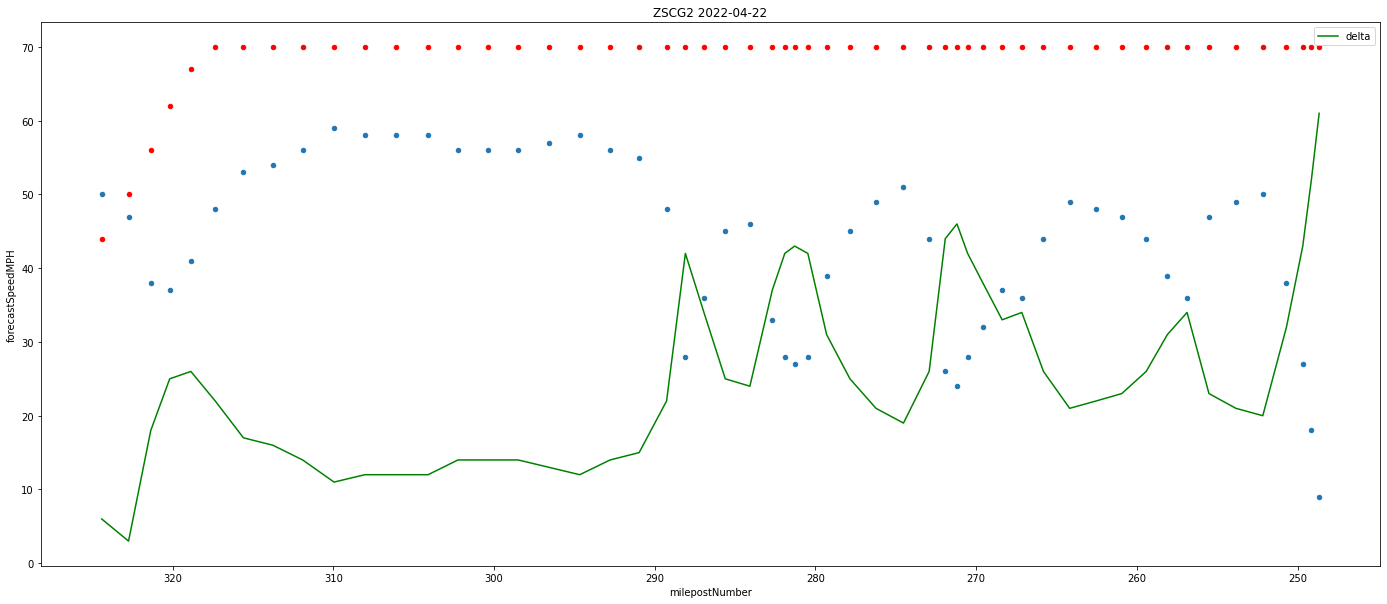

In [78]:
plotTrain(trains, trainIdsList[12])

In [90]:
trains.head()

,index,positionTime_beop,forecastSpeedMPH,forecastTrackName,forecastMilepostNumber,positionTime_actual,speedMPH,trackName,milepostNumber,delta,milepost,millis,trainId
0,0,2022-04-21T23:31:08Z,12,WEST MAIN,766.9304,2022-04-21T23:33:08Z,10.0,WEST MAIN,766.5422,2.0,766,1650583988000,MEWLI 2022-04-21
1,1,2022-04-21T23:33:08Z,19,WEST MAIN,766.4076,2022-04-21T23:35:08Z,10.0,WEST MAIN-MAIN,766.1963,9.0,766,1650584108000,MEWLI 2022-04-21
2,2,2022-04-21T23:35:08Z,25,WEST MAIN,765.6378,2022-04-21T23:37:08Z,10.0,MAIN,765.8565,15.0,765,1650584228000,MEWLI 2022-04-21
3,3,2022-04-21T23:37:08Z,30,WEST MAIN,764.6927,2022-04-21T23:39:08Z,8.0,MAIN,765.5412,22.0,765,1650584348000,MEWLI 2022-04-21
4,4,2022-04-21T23:39:08Z,34,WEST MAIN,763.6077,2022-04-21T23:41:08Z,8.0,MAIN,765.2401,26.0,765,1650584468000,MEWLI 2022-04-21


Text(0.5, 1.0, 'Mean Error')

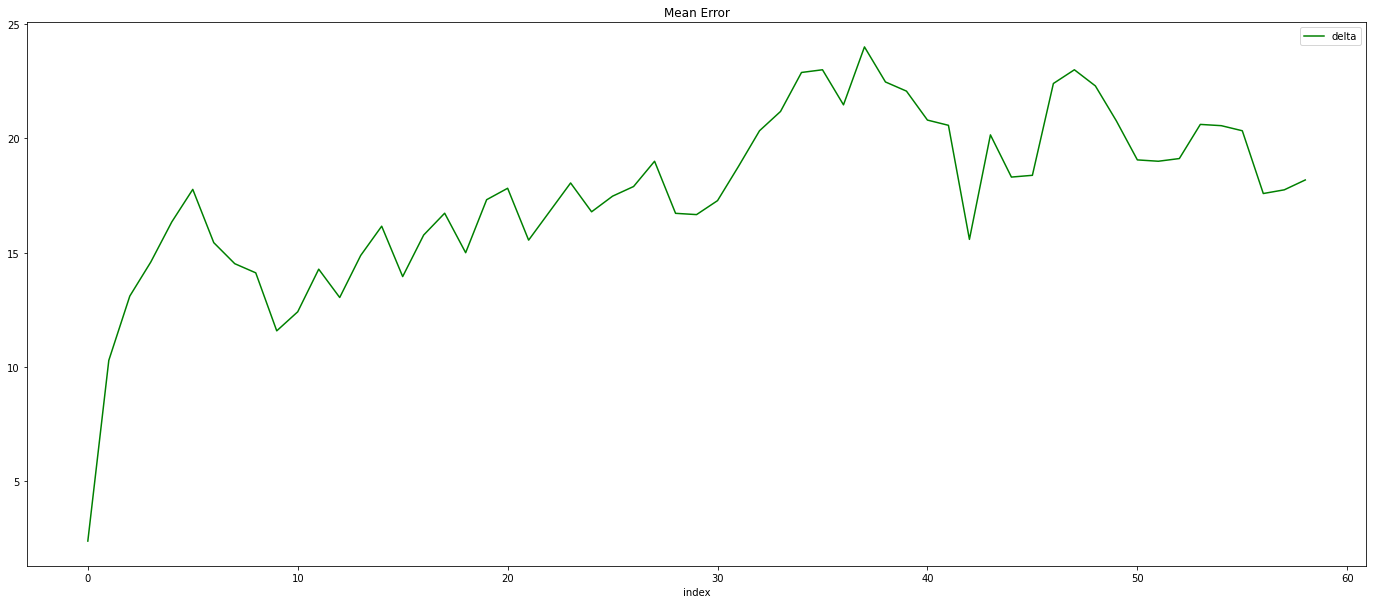

In [100]:
indexedMean = (trains[["index","delta"]]).groupby('index').mean()
indexedMean.plot( y="delta", kind="line", color="green", figsize=[24,10])
plt.title("Mean Error")

In [113]:
meanSquared = math.sqrt((indexedMean['delta']**2).sum())
print("Mean Squared Error: ", meanSquared)

Mean Squared Error:  138.38652511796028
